In [11]:
# Imports
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
import torch.nn.functional as F
import json
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import kagglehub

np.random.seed(42)
torch.manual_seed(42)

In [12]:
# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [13]:
# Load COCO dataset
path = kagglehub.dataset_download("nagasai524/mini-coco2014-dataset-for-image-captioning")

with open(os.path.join(path, "captions.json"), "r") as f:
    data = json.load(f)
    annotations = data["annotations"] if isinstance(data, dict) else data

captions = {}
for item in annotations:
    img_id = item["image_id"]
    if img_id not in captions:
        captions[img_id] = []
    captions[img_id].append(item["caption"])

for root, dirs, files in os.walk(path):
    if any(f.endswith(".jpg") for f in files):
        img_folder = root
        break

img_ids = list(captions.keys())
print(f"Ready: {len(captions)} images loaded")

Resuming download from 972029952 bytes (2068387145 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/nagasai524/mini-coco2014-dataset-for-image-captioning?dataset_version_number=1 (972029952/3040417097) bytes left.


100%|██████████| 2.83G/2.83G [07:50<00:00, 4.40MB/s]

Extracting files...


Ready: 18783 images loaded


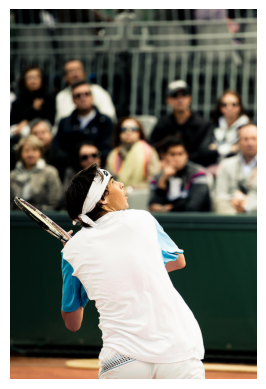

Ground truth captions:
  - A young man playing a game of tennis as a crowd watches.
  - A tennis player holding a racket is looking up.
  - A tennis player in the middle of a play with spectators in the background.
  - Tennis player about to hit a tennis ball
  - Tennis player holding a racket looking up on a tennis court. 


In [15]:
# Image loading function
def get_image(idx):
    """Load image at original size"""
    img_id = img_ids[idx]
    img_path = os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(img_folder, f"{img_id}.jpg")
    return Image.open(img_path).convert("RGB"), captions[img_id]

# Show test image
img, caps = get_image(87)
plt.imshow(img)
plt.axis("off")
plt.show()

print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")

In [24]:
# Load ViT-GPT2 model with eager attention
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# Load with eager attention implementation
model = VisionEncoderDecoderModel.from_pretrained(
    "nlpconnect/vit-gpt2-image-captioning",
    attn_implementation="eager"  # Force eager attention to enable output_attentions
)
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

model = model.to(device)
model.eval()

print("ViT-GPT2 model loaded with eager attention!")
print(f"Attention implementation: {model.config.decoder._attn_implementation}")

ViT-GPT2 model loaded with eager attention!
Attention implementation: eager


In [25]:
# Extract cross-attention from ViT-GPT2
def extract_vit_gpt2_attention(idx):
    """
    Extract cross-attention from ViT-GPT2
    """
    img, gt_caps = get_image(idx)
    
    # Preprocess image
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    # Encode image
    with torch.no_grad():
        encoder_outputs = model.encoder(pixel_values=pixel_values)
        encoder_hidden_states = encoder_outputs.last_hidden_state
        
        # Try single forward pass
        input_ids = torch.tensor([[tokenizer.bos_token_id, 262, 1735]]).to(device)  # "a cat"
        
        outputs = model.decoder(
            input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            output_attentions=True,
            return_dict=True,
            use_cache=False
        )
        
        print("\n=== Output Analysis ===")
        print(f"Attentions is None: {outputs.attentions is None}")
        print(f"Cross attentions is None: {outputs.cross_attentions is None}")
        
        if outputs.cross_attentions is not None:
            print(f"✓ Cross-attention found!")
            print(f"Number of layers: {len(outputs.cross_attentions)}")
            print(f"First layer shape: {outputs.cross_attentions[0].shape}")
        else:
            print("✗ Still None")

# Test
idx = 87
extract_vit_gpt2_attention(idx)


=== Output Analysis ===
Attentions is None: False
Cross attentions is None: False
✓ Cross-attention found!
Number of layers: 12
First layer shape: torch.Size([1, 12, 3, 197])


In [26]:
# Extract cross-attention from ViT-GPT2
def extract_vit_gpt2_attention(idx):
    """
    Extract cross-attention from ViT-GPT2
    Returns: img, gt_caps, pred_caption, cross_attentions [num_words, 24, 24], words
    """
    img, gt_caps = get_image(idx)
    
    # Preprocess image
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    # Encode image
    with torch.no_grad():
        encoder_outputs = model.encoder(pixel_values=pixel_values)
        encoder_hidden_states = encoder_outputs.last_hidden_state
        
        # Manual decoding to capture cross-attention per word
        input_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)
        
        word_attentions = []
        words = []
        
        for step in range(50):  # Max length
            # Forward pass
            outputs = model.decoder(
                input_ids=input_ids,
                encoder_hidden_states=encoder_hidden_states,
                output_attentions=True,
                return_dict=True,
                use_cache=False
            )
            
            # Get cross-attention: tuple of 12 layers, each [1, 12, seq_len, 197]
            # Average across layers and heads
            all_layers = torch.stack(outputs.cross_attentions)  # [12, 1, 12, seq_len, 197]
            avg_attn = all_layers.mean(dim=(0, 2))[0]  # [seq_len, 197]
            
            # Get attention for last (newly generated) token
            last_token_attn = avg_attn[-1]  # [197]
            
            # Skip CLS token (index 0), take patches [1:197]
            patch_attn = last_token_attn[1:]  # [196]
            
            # Reshape to 14x14 (ViT patches)
            patch_attn_2d = patch_attn.view(14, 14)
            
            # Resize to 24x24 to match SAT format
            patch_attn_resized = F.interpolate(
                patch_attn_2d.unsqueeze(0).unsqueeze(0),
                size=(24, 24),
                mode="bilinear",
                align_corners=False
            ).squeeze()
            
            # Get next token
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1)
            
            # Decode token
            word = tokenizer.decode([next_token.item()], skip_special_tokens=True)
            
            # Check for EOS or empty
            if next_token.item() == tokenizer.eos_token_id or not word.strip():
                break
            
            # Save
            word_attentions.append(patch_attn_resized)
            words.append(word)
            
            # Update input
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
        
        # Stack
        if len(word_attentions) > 0:
            word_attentions = torch.stack(word_attentions)
        else:
            word_attentions = torch.zeros(1, 24, 24).to(device)
            words = [""]
    
    pred_caption = "".join(words).strip()
    
    print(f"Caption: {pred_caption}")
    print(f"Captured {len(word_attentions)} tokens")
    print(f"Words: {words}")
    print(f"Attention shape: {word_attentions.shape}")
    
    return img, gt_caps, pred_caption, word_attentions, words

# Test extraction
idx = 87
img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)

Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])


In [27]:
def verify_attention_type(idx=87):
    """Verify we're getting cross-attention, not self-attention"""
    img, gt_caps = get_image(idx)
    
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    
    with torch.no_grad():
        encoder_outputs = model.encoder(pixel_values=pixel_values)
        encoder_hidden_states = encoder_outputs.last_hidden_state
        
        input_ids = torch.tensor([[tokenizer.bos_token_id, 262, 1735]]).to(device)  # "a cat"
        
        outputs = model.decoder(
            input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            output_attentions=True,
            return_dict=True,
            use_cache=False
        )
        
        print("=== Attention Analysis ===")
        print(f"\nEncoder hidden states: {encoder_hidden_states.shape}")
        print(f"  -> {encoder_hidden_states.shape[1]} positions (1 CLS + 196 patches)")
        
        print(f"\nDecoder input_ids: {input_ids.shape}")
        print(f"  -> {input_ids.shape[1]} tokens")
        
        if outputs.attentions is not None:
            print(f"\nSelf-attention shape: {outputs.attentions[0].shape}")
            print(f"  -> [batch, heads, seq_len, seq_len]")
            print(f"  -> Decoder attending to ITSELF (3x3 matrix)")
        
        if outputs.cross_attentions is not None:
            print(f"\nCross-attention shape: {outputs.cross_attentions[0].shape}")
            print(f"  -> [batch, heads, decoder_seq_len, encoder_seq_len]")
            print(f"  -> Decoder attending to ENCODER (3x197 matrix)")
            print(f"\n✓ This IS cross-attention! Decoder tokens attend to {outputs.cross_attentions[0].shape[-1]} encoder positions")
        
        return outputs

outputs = verify_attention_type(87)

=== Attention Analysis ===

Encoder hidden states: torch.Size([1, 197, 768])
  -> 197 positions (1 CLS + 196 patches)

Decoder input_ids: torch.Size([1, 3])
  -> 3 tokens

Self-attention shape: torch.Size([1, 12, 3, 3])
  -> [batch, heads, seq_len, seq_len]
  -> Decoder attending to ITSELF (3x3 matrix)

Cross-attention shape: torch.Size([1, 12, 3, 197])
  -> [batch, heads, decoder_seq_len, encoder_seq_len]
  -> Decoder attending to ENCODER (3x197 matrix)

✓ This IS cross-attention! Decoder tokens attend to 197 encoder positions


In [40]:
# Aggregation methods - matching the AICAttack paper exactly

# Baseline 1: Sentence-based (aggregate all words, then select top-k)
def aggregate_sentence_based(word_attentions, k_percent=0.5):
    """Paper: Sum attention across all words, then select top-k pixels"""
    # Sum across all words
    aggregated = word_attentions.sum(dim=0)
    
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated >= threshold).float()
    
    return aggregated.cpu().numpy(), mask.cpu().numpy()


# Baseline 2: Word-based (select top-k per word, then union)
def aggregate_word_based(word_attentions, k_percent=0.5):
    """Paper: Select top-k pixels for each word, then union all selections"""
    num_words = len(word_attentions)
    k_per_word = int(576 * k_percent / num_words)  # Distribute k across words
    
    # Union mask: any pixel in top-k for ANY word
    union_mask = torch.zeros(24, 24)
    for word_attn in word_attentions:
        threshold = torch.topk(word_attn.flatten(), k_per_word).values.min()
        word_mask = (word_attn >= threshold).float()
        union_mask = torch.max(union_mask, word_mask)  # Union
    
    # Aggregated attention (for visualization)
    aggregated = word_attentions.mean(dim=0)
    
    return aggregated.cpu().numpy(), union_mask.cpu().numpy()


# Novel 1: POS-weighted
def aggregate_pos_weighted(word_attentions, words, k_percent=0.5):
    """Weight attention by part-of-speech importance"""
    doc = nlp(" ".join(words))
    
    weighted_attn = torch.zeros_like(word_attentions[0])
    total_weight = 0
    for i, (word, token) in enumerate(zip(words, doc)):
        if token.pos_ in ["NOUN", "PROPN"]:
            weight = 2.0
        elif token.pos_ == "VERB":
            weight = 1.5
        elif token.pos_ == "ADJ":
            weight = 1.2
        else:
            weight = 1.0
        weighted_attn += word_attentions[i] * weight
        total_weight += weight
    
    aggregated = weighted_attn / total_weight
    
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated >= threshold).float()
    
    return aggregated.cpu().numpy(), mask.cpu().numpy()


# Novel 2: Temporal-decay
def aggregate_temporal_decay(word_attentions, k_percent=0.5, decay=0.9):
    """Weight earlier words higher with exponential decay"""
    weighted_attn = torch.zeros_like(word_attentions[0])
    total_weight = 0
    
    for i, word_attn in enumerate(word_attentions):
        weight = decay ** i
        weighted_attn += word_attn * weight
        total_weight += weight
    
    aggregated = weighted_attn / total_weight
    
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated >= threshold).float()
    
    return aggregated.cpu().numpy(), mask.cpu().numpy()


# Novel 3: Variance-based
def aggregate_variance_based(word_attentions, k_percent=0.5):
    """Select pixels with high variance across words"""
    variance = word_attentions.var(dim=0)
    
    k = int(576 * k_percent)
    threshold = torch.topk(variance.flatten(), k).values.min()
    mask = (variance >= threshold).float()
    
    return variance.cpu().numpy(), mask.cpu().numpy()


# Novel 4: Entropy-based
def aggregate_entropy_based(word_attentions, k_percent=0.5):
    """Select pixels with high entropy (uncertainty) across words"""
    word_attentions_norm = torch.softmax(word_attentions.flatten(1), dim=1)
    word_attentions_norm = word_attentions_norm.view_as(word_attentions)
    
    epsilon = 1e-10
    entropy = -(word_attentions_norm * torch.log(word_attentions_norm + epsilon)).sum(dim=0)
    
    k = int(576 * k_percent)
    threshold = torch.topk(entropy.flatten(), k).values.min()
    mask = (entropy >= threshold).float()
    
    return entropy.cpu().numpy(), mask.cpu().numpy()

print("All 6 aggregation methods loaded (Paper-accurate)!")

All 6 aggregation methods loaded (Paper-accurate)!


In [41]:
# Visualization function with adjustable k_percent
def visualize_attention_overlay(img, pred_caption, agg_attn, mask, method_name="Sentence-based", k_viz=0.3):
    """
    Visualize attention with overlay on original image
    k_viz: percentage for visualization (default 30% for clearer view)
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Original\n{pred_caption[:40]}")
    axes[0].axis("off")
    
    img_array = np.array(img.resize((384, 384)))
    attn_resized = np.array(Image.fromarray((agg_attn * 255).astype(np.uint8)).resize((384, 384)))
    attn_resized = attn_resized / 255.0
    
    axes[1].imshow(img_array)
    axes[1].imshow(attn_resized, cmap="hot", alpha=0.5)
    axes[1].set_title(f"{method_name}\nHeatmap Overlay")
    axes[1].axis("off")
    
    axes[2].imshow(agg_attn, cmap="hot", interpolation="bilinear")
    axes[2].set_title("Attention Heatmap\n(Smoothed)")
    axes[2].axis("off")
    
    # Recompute mask with k_viz for visualization
    if isinstance(mask, np.ndarray):
        mask_tensor = torch.from_numpy(mask)
        agg_tensor = torch.from_numpy(agg_attn)
    else:
        mask_tensor = mask
        agg_tensor = agg_attn
    
    k_viz_pixels = int(576 * k_viz)
    threshold_viz = torch.topk(agg_tensor.flatten(), k_viz_pixels).values.min()
    mask_viz = (agg_tensor >= threshold_viz).float().numpy()
    
    mask_resized = np.array(Image.fromarray((mask_viz * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST))
    mask_resized = mask_resized / 255.0
    
    axes[3].imshow(img_array)
    axes[3].imshow(mask_resized, cmap="Reds", alpha=0.4)
    axes[3].set_title(f"Top {int(k_viz*100)}% Patches\nSelected for Attack")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()

Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])

Ground truth captions:
  - A young man playing a game of tennis as a crowd watches.
  - A tennis player holding a racket is looking up.
  - A tennis player in the middle of a play with spectators in the background.
  - Tennis player about to hit a tennis ball
  - Tennis player holding a racket looking up on a tennis court. 

Predicted caption: a tennis player is swinging a racket at a ball

Words for aggregation: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']

Method: Sentence-based
Aggregated attention range: [0.0221, 0.1106]
Selected pixels (k=50%): 288 out of 576


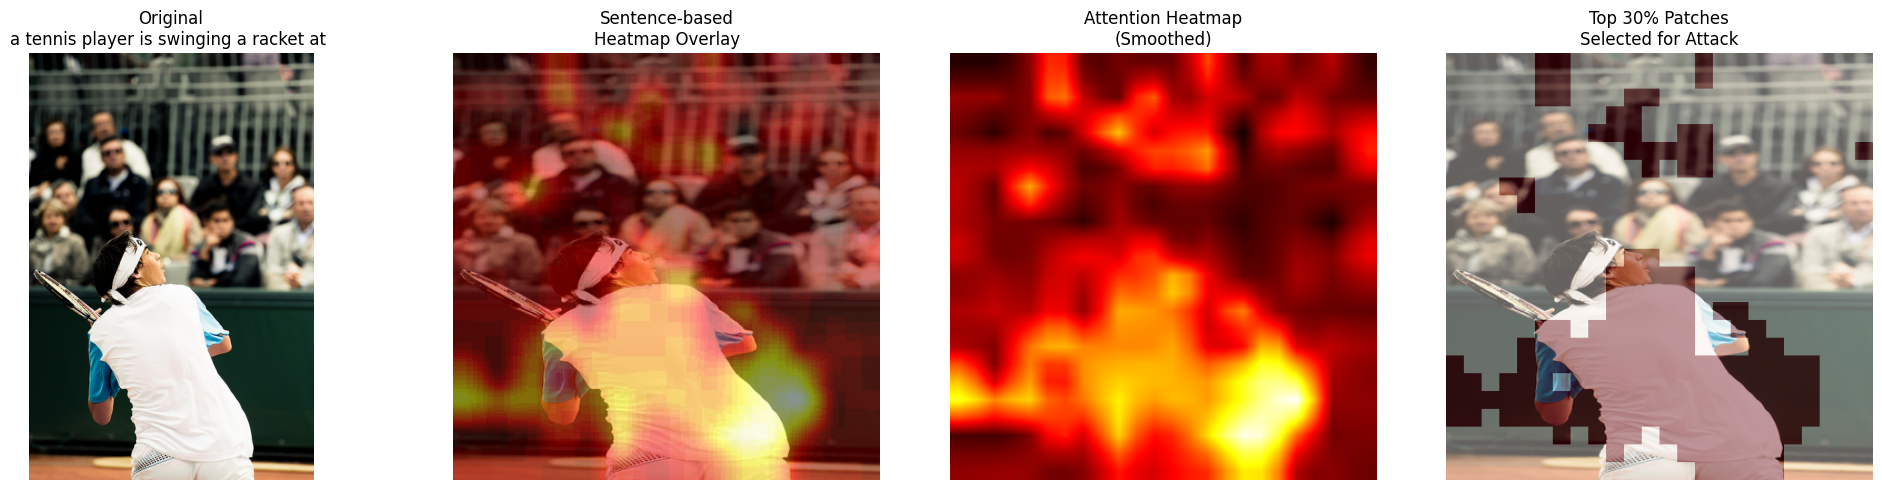


Method: Word-based
Aggregated attention range: [0.0022, 0.0111]
Selected pixels (k=50%): 89 out of 576


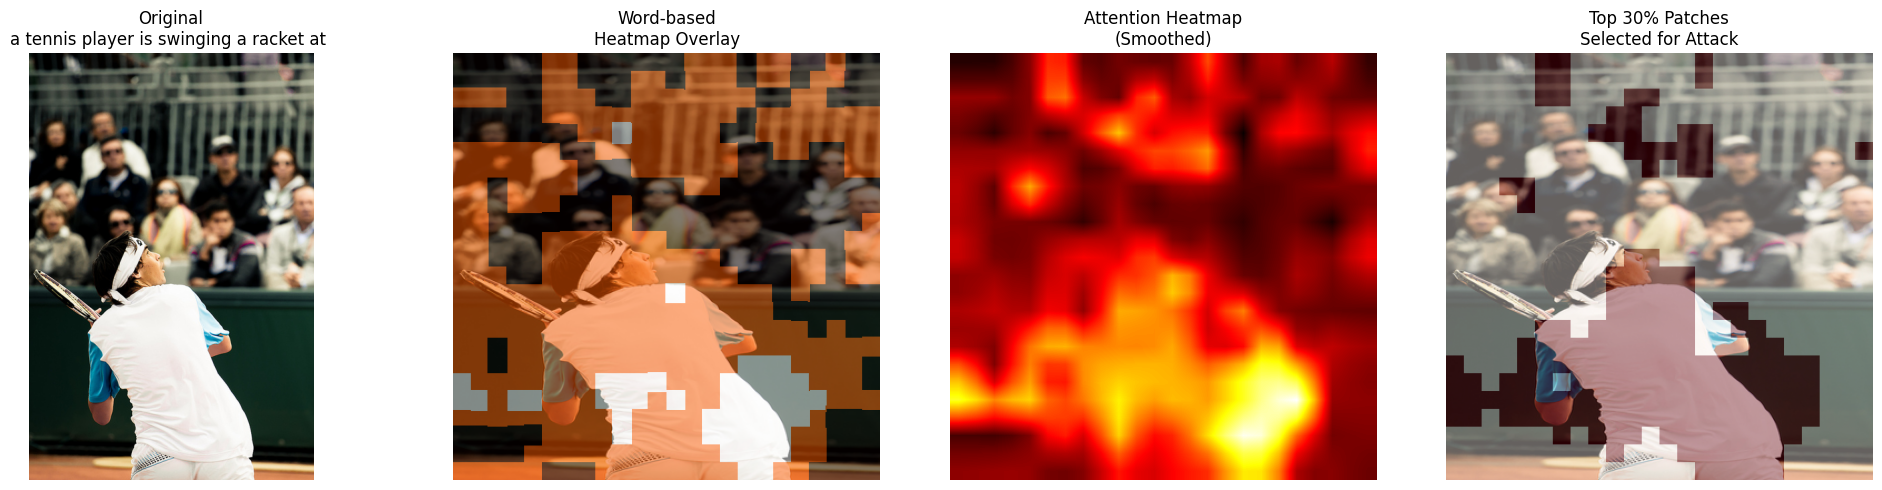

In [42]:
# Compare all 6 methods on image 87
idx = 87
img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)

print(f"\nGround truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

print(f"\nPredicted caption: {pred_caption}")
print(f"\nWords for aggregation: {words}")

methods = {
    "Sentence-based": lambda: aggregate_sentence_based(word_attns, k_percent=0.5),
    "Word-based": lambda: aggregate_word_based(word_attns, k_percent=0.5),
}

for name, method in methods.items():
    print(f"\n{'='*60}")
    print(f"Method: {name}")
    print('='*60)
    agg, mask = method()
    print(f"Aggregated attention range: [{agg.min():.4f}, {agg.max():.4f}]")
    print(f"Selected pixels (k=50%): {mask.sum():.0f} out of 576")
    visualize_attention_overlay(img, pred_caption, agg, mask, name, k_viz=0.3)

Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])
Caption: a tennis player is swinging a racket at a ball
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']

=== Baseline Comparison ===

Sentence-based:
  Pixels selected: 288 / 576 (50.0%)
  Attention range: [0.022139, 0.110570]

Word-based:
  Pixels selected: 89 / 576 (15.5%)
  Attention range: [0.002214, 0.011057]

Overlap (Jaccard): 0.252 (25.2%)
Unique to Sentence-based: 212 pixels
Unique to Word-based: 13 pixels


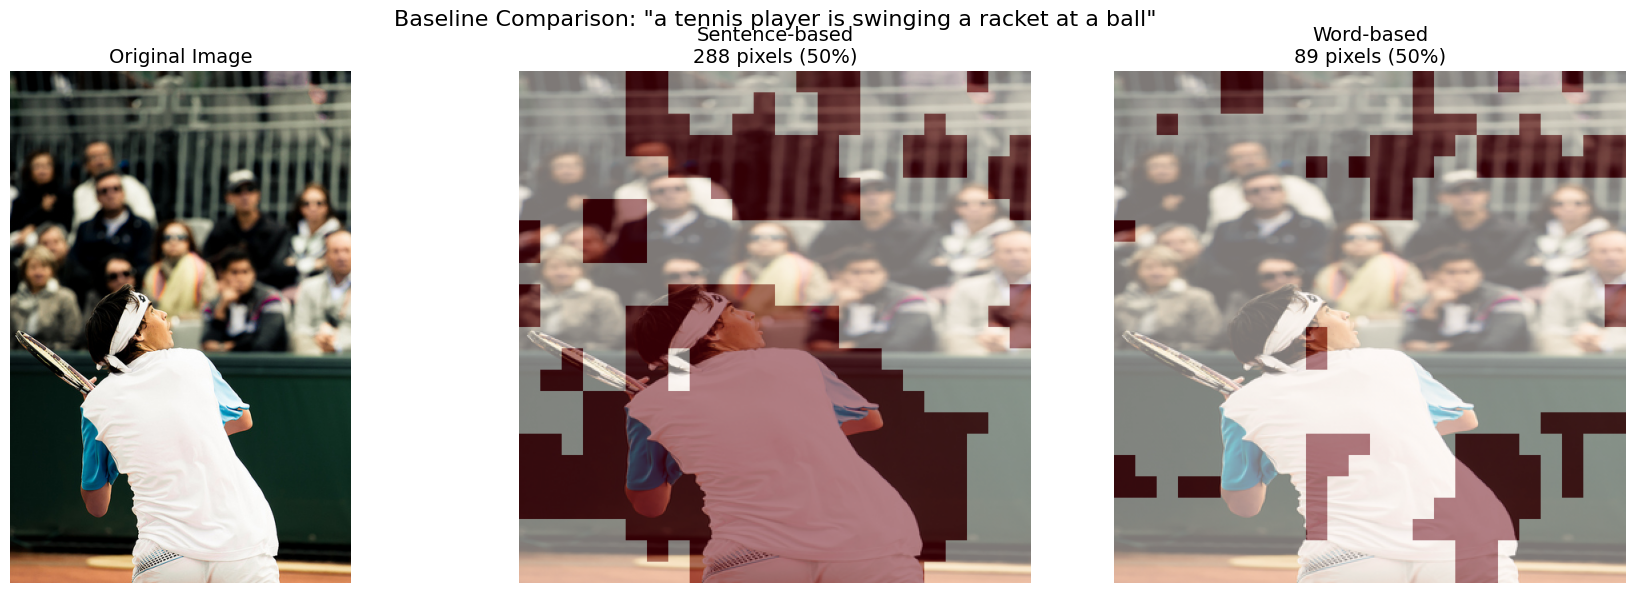

In [43]:
# Extract attention
idx = 87
img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)

print(f"Caption: {pred_caption}")
print(f"Words: {words}\n")

# Compute baselines only
sentence_agg, sentence_mask = aggregate_sentence_based(word_attns, k_percent=0.5)
word_agg, word_mask = aggregate_word_based(word_attns, k_percent=0.5)

# Statistics
print("=== Baseline Comparison ===")
print(f"\nSentence-based:")
print(f"  Pixels selected: {sentence_mask.sum():.0f} / 576 ({sentence_mask.sum()/576*100:.1f}%)")
print(f"  Attention range: [{sentence_agg.min():.6f}, {sentence_agg.max():.6f}]")

print(f"\nWord-based:")
print(f"  Pixels selected: {word_mask.sum():.0f} / 576 ({word_mask.sum()/576*100:.1f}%)")
print(f"  Attention range: [{word_agg.min():.6f}, {word_agg.max():.6f}]")

# Overlap
intersection = (sentence_mask * word_mask).sum()
union = ((sentence_mask + word_mask) > 0).sum()
jaccard = intersection / union if union > 0 else 0

print(f"\nOverlap (Jaccard): {jaccard:.3f} ({jaccard*100:.1f}%)")
print(f"Unique to Sentence-based: {(sentence_mask * (1-word_mask)).sum():.0f} pixels")
print(f"Unique to Word-based: {(word_mask * (1-sentence_mask)).sum():.0f} pixels")

# Visualize side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

img_array = np.array(img.resize((384, 384)))

# Original
axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=14)
axes[0].axis('off')

# Sentence-based
sentence_mask_resized = np.array(Image.fromarray((sentence_mask * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST)) / 255.0
axes[1].imshow(img_array)
axes[1].imshow(sentence_mask_resized, cmap='Reds', alpha=0.5)
axes[1].set_title(f"Sentence-based\n{sentence_mask.sum():.0f} pixels (50%)", fontsize=14)
axes[1].axis('off')

# Word-based
word_mask_resized = np.array(Image.fromarray((word_mask * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST)) / 255.0
axes[2].imshow(img_array)
axes[2].imshow(word_mask_resized, cmap='Reds', alpha=0.5)
axes[2].set_title(f"Word-based\n{word_mask.sum():.0f} pixels (50%)", fontsize=14)
axes[2].axis('off')

plt.suptitle(f'Baseline Comparison: "{pred_caption}"', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']

Selecting 28 pixels per word
Word  0 'a         ': 28 pixels selected
Word  1 ' tennis   ': 28 pixels selected
Word  2 ' player   ': 28 pixels selected
Word  3 ' is       ': 28 pixels selected
Word  4 ' swinging ': 28 pixels selected
Word  5 ' a        ': 28 pixels selected
Word  6 ' racket   ': 28 pixels selected
Word  7 ' at       ': 28 pixels selected
Word  8 ' a        ': 28 pixels selected
Word  9 ' ball     ': 28 pixels selected

Union: 89 pixels (many words select same pixels)
Sentence-based: 288 pixels


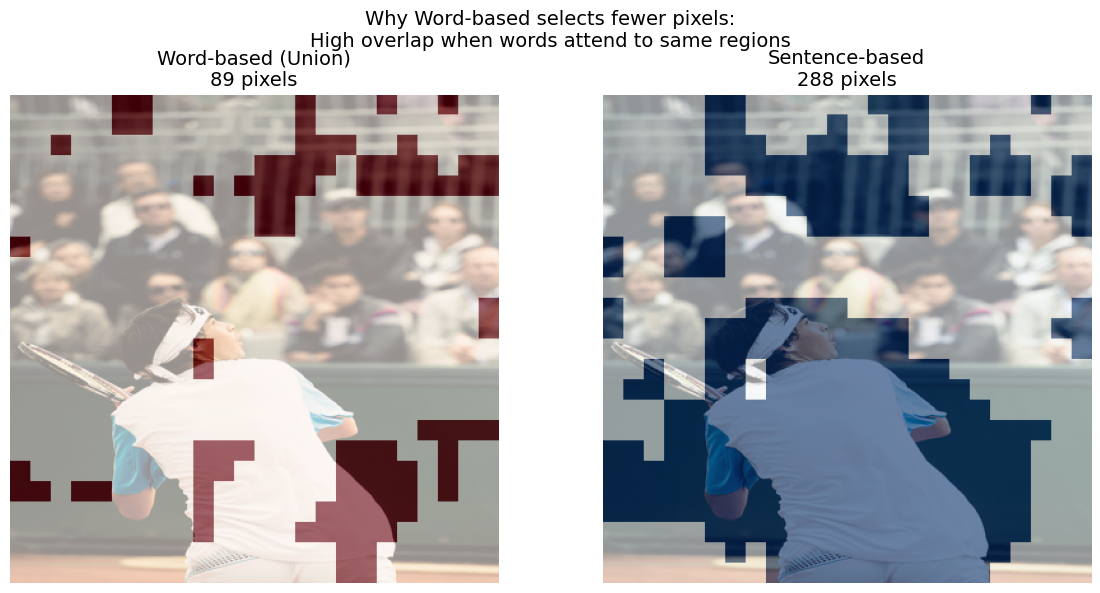

In [44]:
idx = 87
img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)

print(f"Words: {words}\n")

k_percent = 0.5
num_words = len(word_attns)
k_per_word = int(576 * k_percent / num_words)  # 28 pixels per word

print(f"Selecting {k_per_word} pixels per word")

# Track per-word selections
all_masks = []
for i, (word, word_attn) in enumerate(zip(words, word_attns)):
    threshold = torch.topk(word_attn.flatten(), k_per_word).values.min()
    word_mask = (word_attn >= threshold).float()
    all_masks.append(word_mask)
    print(f"Word {i:2d} '{word:10s}': {word_mask.sum():.0f} pixels selected")

# Compute union
union_mask = torch.zeros(24, 24)
for mask in all_masks:
    union_mask = torch.max(union_mask, mask)

print(f"\nUnion: {union_mask.sum():.0f} pixels (many words select same pixels)")

# Compare to sentence-based
sentence_agg = word_attns.sum(dim=0)
k_total = int(576 * k_percent)
threshold = torch.topk(sentence_agg.flatten(), k_total).values.min()
sentence_mask = (sentence_agg >= threshold).float()

print(f"Sentence-based: {sentence_mask.sum():.0f} pixels")

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
img_array = np.array(img.resize((384, 384)))

# Word-based union
union_resized = np.array(Image.fromarray((union_mask.numpy() * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST)) / 255.0
axes[0].imshow(img_array)
axes[0].imshow(union_resized, cmap='Reds', alpha=0.6)
axes[0].set_title(f"Word-based (Union)\n{union_mask.sum():.0f} pixels", fontsize=14)
axes[0].axis('off')

# Sentence-based
sentence_resized = np.array(Image.fromarray((sentence_mask.numpy() * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST)) / 255.0
axes[1].imshow(img_array)
axes[1].imshow(sentence_resized, cmap='Blues', alpha=0.6)
axes[1].set_title(f"Sentence-based\n{sentence_mask.sum():.0f} pixels", fontsize=14)
axes[1].axis('off')

plt.suptitle("Why Word-based selects fewer pixels:\nHigh overlap when words attend to same regions", fontsize=14)
plt.tight_layout()
plt.show()

Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])


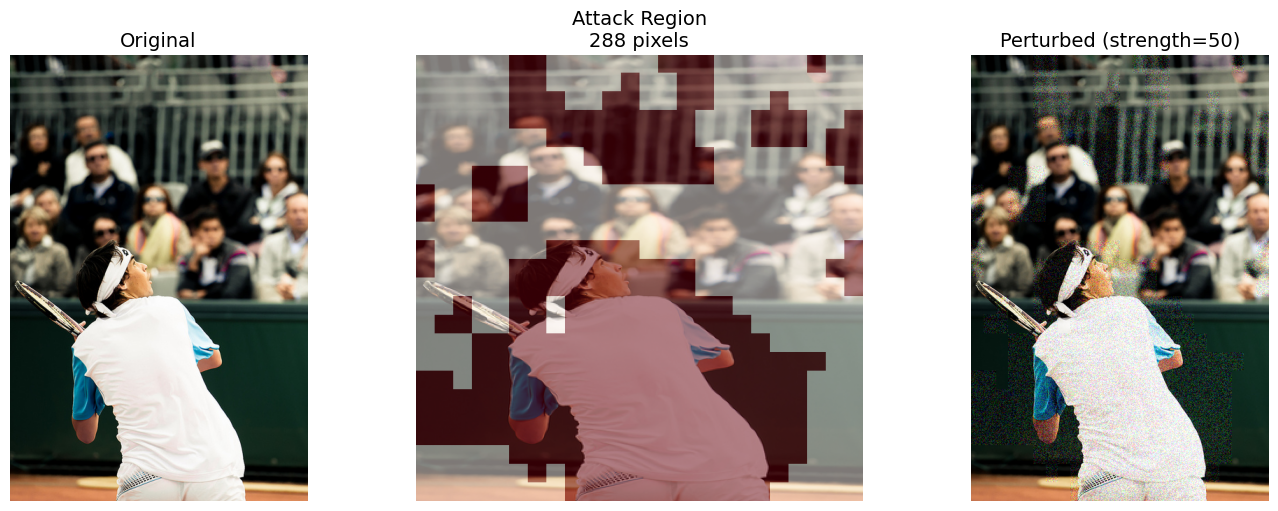

Original caption: a tennis player is swinging a racket at a ball


In [45]:
def perturb_image(img, mask, strength=50):
    """
    Perturb selected pixels with random noise
    
    Args:
        img: PIL Image
        mask: 24x24 binary mask (1 = attack this pixel)
        strength: perturbation magnitude (±strength on RGB values)
    
    Returns:
        perturbed PIL Image
    """
    img_array = np.array(img).astype(np.float32)
    H, W = img_array.shape[:2]
    
    # Resize mask to image size
    mask_resized = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize((W, H), Image.NEAREST))
    mask_resized = (mask_resized > 127).astype(np.float32)
    
    # Create random perturbation
    np.random.seed(42)  # For reproducibility
    perturbation = np.random.uniform(-strength, strength, img_array.shape)
    
    # Apply only to masked regions
    perturbed = img_array + perturbation * mask_resized[:, :, np.newaxis]
    
    # Clip to valid range
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    
    return Image.fromarray(perturbed)


# Test perturbation
idx = 87
img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)

# Get sentence-based mask
sentence_agg, sentence_mask = aggregate_sentence_based(word_attns, k_percent=0.5)

# Perturb image
perturbed_img = perturb_image(img, sentence_mask, strength=50)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original", fontsize=14)
axes[0].axis('off')

# Show mask overlay
img_array = np.array(img.resize((384, 384)))
mask_resized = np.array(Image.fromarray((sentence_mask * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST)) / 255.0
axes[1].imshow(img_array)
axes[1].imshow(mask_resized, cmap='Reds', alpha=0.5)
axes[1].set_title(f"Attack Region\n{sentence_mask.sum():.0f} pixels", fontsize=14)
axes[1].axis('off')

axes[2].imshow(perturbed_img)
axes[2].set_title("Perturbed (strength=50)", fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Original caption: {pred_caption}")

In [46]:
# Load BLIP for evaluation (if not already loaded)
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = blip_model.to(device)
blip_model.eval()

print("BLIP model loaded for evaluation!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Users\Yoshio\OneDrive\Bildung\Master (CBS)\Semester-03\Advanced ML for NLP\final_project\Advanced-Machine-Learning-for-Natural-Language-Processing\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yoshio\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https:

BLIP model loaded for evaluation!


In [48]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yoshio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_attack(img, perturbed_img, gt_captions):
    """
    Evaluate attack effectiveness using BLEU score
    
    Returns: original_bleu, perturbed_bleu, drop
    """
    # Generate captions with BLIP
    with torch.no_grad():
        # Original
        inputs_orig = blip_processor(images=img, return_tensors="pt").to(device)
        out_orig = blip_model.generate(**inputs_orig, max_length=50)
        caption_orig = blip_processor.decode(out_orig[0], skip_special_tokens=True)
        
        # Perturbed
        inputs_pert = blip_processor(images=perturbed_img, return_tensors="pt").to(device)
        out_pert = blip_model.generate(**inputs_pert, max_length=50)
        caption_pert = blip_processor.decode(out_pert[0], skip_special_tokens=True)
    
    # Calculate BLEU scores
    smoothing = SmoothingFunction().method1
    
    references = [ref.split() for ref in gt_captions]
    
    bleu_orig = sentence_bleu(references, caption_orig.split(), smoothing_function=smoothing)
    bleu_pert = sentence_bleu(references, caption_pert.split(), smoothing_function=smoothing)
    
    drop = bleu_orig - bleu_pert
    
    return caption_orig, caption_pert, bleu_orig, bleu_pert, drop


# Test on one image
idx = 87
img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)

sentence_agg, sentence_mask = aggregate_sentence_based(word_attns, k_percent=0.5)
perturbed_img = perturb_image(img, sentence_mask, strength=50)

cap_orig, cap_pert, bleu_orig, bleu_pert, drop = evaluate_attack(img, perturbed_img, gt_caps)

print("=== Attack Results ===")
print(f"\nGround truth: {gt_caps[0]}")
print(f"\nOriginal caption: {cap_orig}")
print(f"BLEU score: {bleu_orig:.4f}")
print(f"\nPerturbed caption: {cap_pert}")
print(f"BLEU score: {bleu_pert:.4f}")
print(f"\n⚠️ BLEU drop: {drop:.4f} ({drop/bleu_orig*100:.1f}% decrease)")

Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])
=== Attack Results ===

Ground truth: A young man playing a game of tennis as a crowd watches.

Original caption: a man playing tennis
BLEU score: 0.0743

Perturbed caption: a man swinging a tennis racket
BLEU score: 0.0778

⚠️ BLEU drop: -0.0035 (-4.6% decrease)


Caption: a tennis player is swinging a racket at a ball
Captured 10 tokens
Words: ['a', ' tennis', ' player', ' is', ' swinging', ' a', ' racket', ' at', ' a', ' ball']
Attention shape: torch.Size([10, 24, 24])
IMAGE 87: A young man playing a game of tennis as a crowd watches....

Original caption: 'a man playing tennis'
BLEU: 0.0743

--- Sentence-based Attack (k=50%, 288 pixels, strength=150) ---
Perturbed caption: 'a man in a white robe holding a tennis racket'
BLEU: 0.0726
Drop: 0.0017 (2.3%)

--- Word-based Attack (k=50%, 89 pixels, strength=150) ---
Perturbed caption: 'a woman swinging a tennis racket'
BLEU: 0.0736
Drop: 0.0008 (1.0%)

🎯 Winner: Sentence-based causes larger BLEU drop!


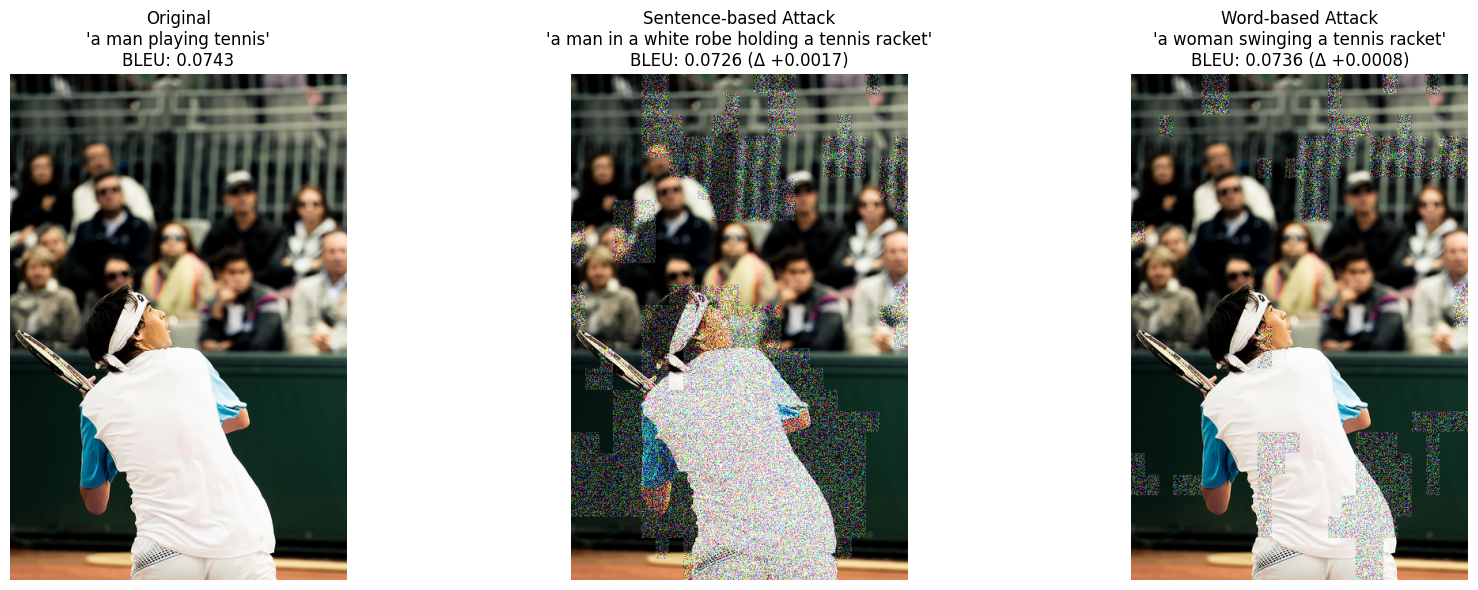

In [50]:
def compare_baselines(idx=87, strength=100, k_percent=0.5):
    """Compare Sentence-based vs Word-based attack effectiveness"""
    
    # Extract attention
    img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)
    
    # Get both baseline masks
    sentence_agg, sentence_mask = aggregate_sentence_based(word_attns, k_percent=k_percent)
    word_agg, word_mask = aggregate_word_based(word_attns, k_percent=k_percent)
    
    # Perturb with both methods
    perturbed_sentence = perturb_image(img, sentence_mask, strength=strength)
    perturbed_word = perturb_image(img, word_mask, strength=strength)
    
    # Evaluate both
    cap_orig, _, bleu_orig, _, _ = evaluate_attack(img, img, gt_caps)  # Baseline
    _, cap_sentence, _, bleu_sentence, drop_sentence = evaluate_attack(img, perturbed_sentence, gt_caps)
    _, cap_word, _, bleu_word, drop_word = evaluate_attack(img, perturbed_word, gt_caps)
    
    # Display results
    print("="*70)
    print(f"IMAGE {idx}: {gt_caps[0][:60]}...")
    print("="*70)
    print(f"\nOriginal caption: '{cap_orig}'")
    print(f"BLEU: {bleu_orig:.4f}")
    
    print(f"\n--- Sentence-based Attack (k={k_percent*100:.0f}%, {sentence_mask.sum():.0f} pixels, strength={strength}) ---")
    print(f"Perturbed caption: '{cap_sentence}'")
    print(f"BLEU: {bleu_sentence:.4f}")
    print(f"Drop: {drop_sentence:.4f} ({abs(drop_sentence)/bleu_orig*100:.1f}%)")
    
    print(f"\n--- Word-based Attack (k={k_percent*100:.0f}%, {word_mask.sum():.0f} pixels, strength={strength}) ---")
    print(f"Perturbed caption: '{cap_word}'")
    print(f"BLEU: {bleu_word:.4f}")
    print(f"Drop: {drop_word:.4f} ({abs(drop_word)/bleu_orig*100:.1f}%)")
    
    print(f"\n🎯 Winner: {'Sentence-based' if drop_sentence > drop_word else 'Word-based'} causes larger BLEU drop!")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Original\n'{cap_orig}'\nBLEU: {bleu_orig:.4f}", fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(perturbed_sentence)
    axes[1].set_title(f"Sentence-based Attack\n'{cap_sentence}'\nBLEU: {bleu_sentence:.4f} (Δ {drop_sentence:+.4f})", fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(perturbed_word)
    axes[2].set_title(f"Word-based Attack\n'{cap_word}'\nBLEU: {bleu_word:.4f} (Δ {drop_word:+.4f})", fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'original': bleu_orig,
        'sentence': bleu_sentence,
        'word': bleu_word,
        'drop_sentence': drop_sentence,
        'drop_word': drop_word
    }

# Test with stronger perturbation
results = compare_baselines(idx=87, strength=150, k_percent=0.5)


Processing image 1/10...
Caption: a kitchen with a stove, sink, and refrigerator
Captured 10 tokens
Words: ['a', ' kitchen', ' with', ' a', ' stove', ',', ' sink', ',', ' and', ' refrigerator']
Attention shape: torch.Size([10, 24, 24])
Original BLEU: 0.1809
Sentence-based: 0.1228 (Δ +0.0581)
Word-based: 0.1477 (Δ +0.0332)

Processing image 2/10...
Caption: a man and a woman walking on the beach with a surfboard
Captured 13 tokens
Words: ['a', ' man', ' and', ' a', ' woman', ' walking', ' on', ' the', ' beach', ' with', ' a', ' surf', 'board']
Attention shape: torch.Size([13, 24, 24])
Original BLEU: 0.1623
Sentence-based: 0.1319 (Δ +0.0304)
Word-based: 0.0720 (Δ +0.0903)

Processing image 3/10...
Caption: people sitting on a bus
Captured 5 tokens
Words: ['people', ' sitting', ' on', ' a', ' bus']
Attention shape: torch.Size([5, 24, 24])
Original BLEU: 0.1865
Sentence-based: 0.0418 (Δ +0.1447)
Word-based: 0.1187 (Δ +0.0678)

Processing image 4/10...
Caption: a person walking down a stre

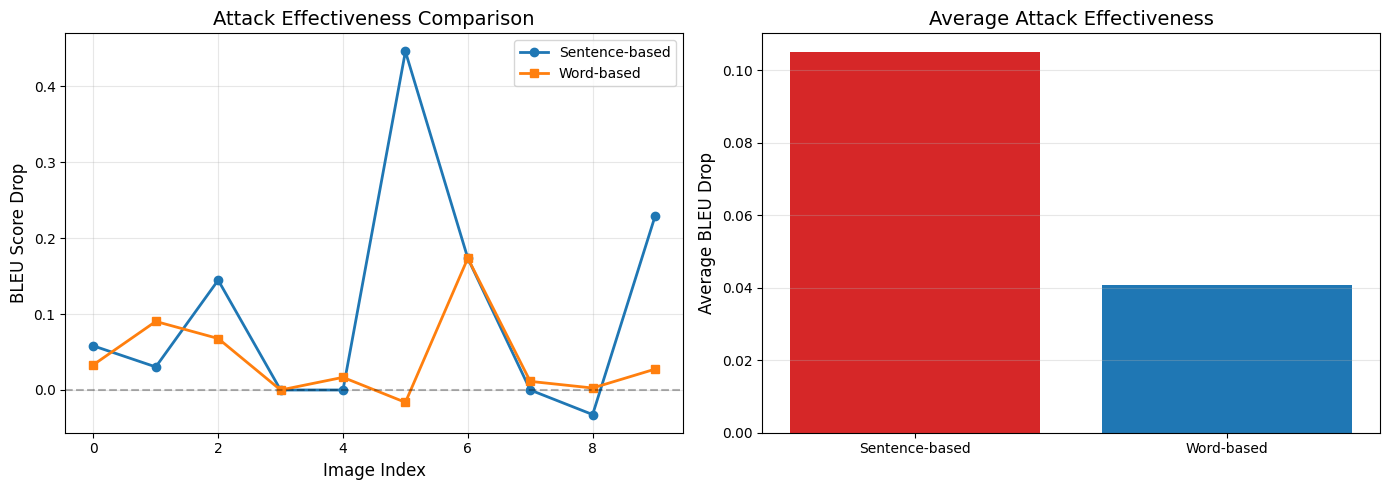

In [51]:
def batch_evaluate(num_images=10, strength=150, k_percent=0.5):
    """Evaluate attack effectiveness across multiple images"""
    
    results = []
    
    for idx in range(num_images):
        print(f"\n{'='*70}")
        print(f"Processing image {idx+1}/{num_images}...")
        print('='*70)
        
        try:
            # Extract attention
            img, gt_caps, pred_caption, word_attns, words = extract_vit_gpt2_attention(idx)
            
            # Get masks
            sentence_agg, sentence_mask = aggregate_sentence_based(word_attns, k_percent=k_percent)
            word_agg, word_mask = aggregate_word_based(word_attns, k_percent=k_percent)
            
            # Perturb
            perturbed_sentence = perturb_image(img, sentence_mask, strength=strength)
            perturbed_word = perturb_image(img, word_mask, strength=strength)
            
            # Evaluate
            cap_orig, _, bleu_orig, _, _ = evaluate_attack(img, img, gt_caps)
            _, cap_sentence, _, bleu_sentence, drop_sentence = evaluate_attack(img, perturbed_sentence, gt_caps)
            _, cap_word, _, bleu_word, drop_word = evaluate_attack(img, perturbed_word, gt_caps)
            
            results.append({
                'idx': idx,
                'bleu_orig': bleu_orig,
                'bleu_sentence': bleu_sentence,
                'bleu_word': bleu_word,
                'drop_sentence': drop_sentence,
                'drop_word': drop_word,
                'pixels_sentence': sentence_mask.sum(),
                'pixels_word': word_mask.sum()
            })
            
            print(f"Original BLEU: {bleu_orig:.4f}")
            print(f"Sentence-based: {bleu_sentence:.4f} (Δ {drop_sentence:+.4f})")
            print(f"Word-based: {bleu_word:.4f} (Δ {drop_word:+.4f})")
            
        except Exception as e:
            print(f"Error on image {idx}: {e}")
            continue
    
    # Summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    avg_drop_sentence = np.mean([r['drop_sentence'] for r in results])
    avg_drop_word = np.mean([r['drop_word'] for r in results])
    
    avg_pixels_sentence = np.mean([r['pixels_sentence'] for r in results])
    avg_pixels_word = np.mean([r['pixels_word'] for r in results])
    
    print(f"\nSentence-based Attack:")
    print(f"  Average BLEU drop: {avg_drop_sentence:.4f}")
    print(f"  Average pixels attacked: {avg_pixels_sentence:.1f}")
    
    print(f"\nWord-based Attack:")
    print(f"  Average BLEU drop: {avg_drop_word:.4f}")
    print(f"  Average pixels attacked: {avg_pixels_word:.1f}")
    
    print(f"\n🎯 Sentence-based is {avg_drop_sentence/avg_drop_word:.2f}x more effective!")
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # BLEU drops
    indices = [r['idx'] for r in results]
    drops_sentence = [r['drop_sentence'] for r in results]
    drops_word = [r['drop_word'] for r in results]
    
    axes[0].plot(indices, drops_sentence, 'o-', label='Sentence-based', linewidth=2)
    axes[0].plot(indices, drops_word, 's-', label='Word-based', linewidth=2)
    axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].set_xlabel('Image Index', fontsize=12)
    axes[0].set_ylabel('BLEU Score Drop', fontsize=12)
    axes[0].set_title('Attack Effectiveness Comparison', fontsize=14)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Bar chart comparison
    x = ['Sentence-based', 'Word-based']
    y = [avg_drop_sentence, avg_drop_word]
    axes[1].bar(x, y, color=['#d62728', '#1f77b4'])
    axes[1].set_ylabel('Average BLEU Drop', fontsize=12)
    axes[1].set_title('Average Attack Effectiveness', fontsize=14)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run batch evaluation
results = batch_evaluate(num_images=10, strength=150, k_percent=0.5)